In [1]:
%config IPCompleter.greedy=True

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import variational_autoencoder as vae

print("Tensor Flow version {}".format(tf.__version__))



D:\z_outsourced_programs\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensor Flow version 1.8.0


In [3]:
#test utils
import weapon_data as weapons

def print_decoded_tensors_as_dict(weapon_data, array_of_tensors):
    genDict = {}
    
    for tensor in array_of_tensors:
        decoded, _ = weapon_data.decode_processed_tensor(tensor)
        
        for key, value in decoded.items():
            if key not in genDict:
                genDict[key] = []
            genDict[key].append(value)
    
    for key, value in genDict.items():
            print(key, "=", value)
            
            
def get_weapon_data():
    return weapons.get_data()

In [4]:
network_architecture = \
    dict(n_input=0, #set it in with scope
         n_hidden_1=26,
         n_hidden_2=12,
         n_z=2)  

learning_rate = 0.01
optimizer =  tf.train.RMSPropOptimizer(learning_rate)
transfer_fct = tf.nn.elu
num_epochs = 100
batch_size = 4
epoch_debug_step = 1
    
with tf.Session() as sess:
    train_data, test_data = get_weapon_data()
    network_architecture['n_input'] = train_data.num_features
  
    network = vae.get_new_trained(sess, train_data, network_architecture, optimizer, 
                              transfer_fct, batch_size, num_epochs, epoch_debug_step)


Epoch:0001 - Cost:23.721057411
Epoch:0002 - Cost:17.459637409
Epoch:0003 - Cost:16.314922303
Epoch:0004 - Cost:15.568019537
Epoch:0005 - Cost:14.469770086
Epoch:0006 - Cost:14.109629593
Epoch:0007 - Cost:13.291733569
Epoch:0008 - Cost:12.337518842
Epoch:0009 - Cost:12.884009939
Epoch:0010 - Cost:11.449108710
Epoch:0011 - Cost:12.617828189
Epoch:0012 - Cost:11.225397425
Epoch:0013 - Cost:12.049022179
Epoch:0014 - Cost:11.804731354
Epoch:0015 - Cost:10.872297287
Epoch:0016 - Cost:11.365120430
Epoch:0017 - Cost:10.359257480
Epoch:0018 - Cost:11.645253414
Epoch:0019 - Cost:10.396168416
Epoch:0020 - Cost:11.079435589
Epoch:0021 - Cost:11.569516325
Epoch:0022 - Cost:9.732325606
Epoch:0023 - Cost:10.834690800
Epoch:0024 - Cost:10.803492614
Epoch:0025 - Cost:10.141385687
Epoch:0026 - Cost:10.028522597
Epoch:0027 - Cost:11.094065509
Epoch:0028 - Cost:10.418133848
Epoch:0029 - Cost:10.210249968
Epoch:0030 - Cost:9.825441285
Epoch:0031 - Cost:10.134525795
Epoch:0032 - Cost:9.293142634
Epoch:0033 

In [5]:
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")
        
    train_data, test_data = get_weapon_data()
    
    samples = test_data.next_batch(batch_size)
    x_reconstructed = network.encode_and_decode(samples, True)
    print_decoded_tensors_as_dict(test_data, np.concatenate((samples,x_reconstructed), axis=0))


with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")

    train_data, test_data = get_weapon_data()
    
    samples = test_data.next_batch(1)
    x_reconstructed_mean = network.encode_and_decode(samples, False)
    print_decoded_tensors_as_dict(test_data, np.concatenate((samples,[x_reconstructed_mean]), axis=0))

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
damages_first = ['53.0', '38.0', '26.5', '80.0', '33.54171915208097', '22.9417303179533', '26.30971692785881', '31.32514793544796']
damages_last = ['38.0', '21.5', '23.0', '80.0', '25.592233039872163', '12.212289190820734', '18.787008627949895', '13.008203006077332']
dmg_distances_first = ['66.0', '10.0', '11.0', '0.0', '52.82091890530678', '6.325438159549687', '17.383235462518435', '13.189530193284142']
dmg_distances_last = ['89.0', '47.0', '35.0', '115.0', '65.23942536302799', '29.09563548667389', '33.49498553421313', '38.09845333791813']
firemode_Automatic = ['0.0', '1.0', '1.0', '0.0', '0.20620344596667695', '0.6787885441099946', '1.2071597476773168', '0.01753992349233857']
firemode_Semi-Automatic = ['1.0', '0.0', '0.0', '0.0', '0.8128540337304877', '0.44223334189988694', '-0.09637685592308592', '0.9745681800087188']
firemode_Single-Action = ['0.0', '0.0', '0.0', '1.0', '-0.06215683039630843', '-0.07722632254817435', 

In [6]:
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")
    
    avg_cost_rand = 0.
    avg_cost = 0.

    _, test_data = get_weapon_data()
    num_samples = test_data.num_examples
    total_batch = int(num_samples / batch_size)

    # Loop over all batches
    for i in range(total_batch):
        batch = test_data.next_batch(batch_size)
        cost = network.calculate_loss(batch)        

        rand_sample = np.random.uniform(low=test_data.standardized_min_values, 
                                       high=test_data.standardized_max_values, 
                                       size=(batch_size,network_architecture["n_input"]))
        cost_rand = network.calculate_loss(rand_sample)

        print("Random Cost = " + "{:.2f}".format(cost_rand))

        #compute average loss/cost
        avg_cost_rand += min(cost_rand,1000) / batch_size
        avg_cost += cost / batch_size
    
    print("Random input average cost = " + "{:.2f}".format(avg_cost_rand))   
    print("Test data input average cost = " + "{:.2f}".format(avg_cost))


INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
Random Cost = 15537072128.00
Random Cost = 1183886336.00
Random Cost = 2653965312.00
Random Cost = 1514938752.00
Random Cost = 373032320.00
Random input average cost = 1250.00
Test data input average cost = 15.11


INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt


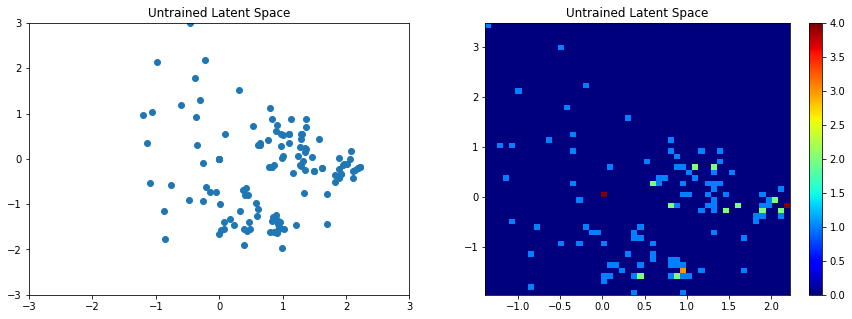

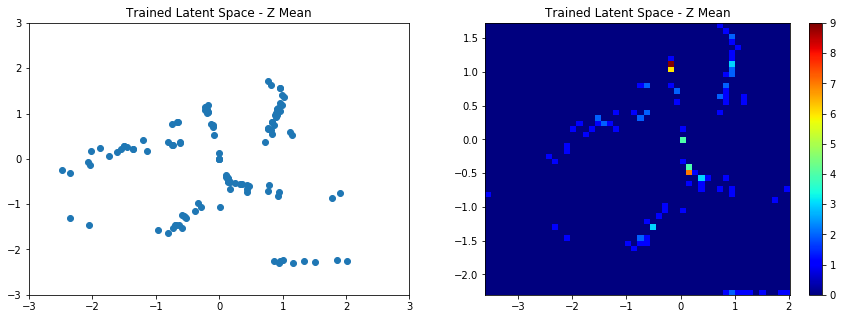

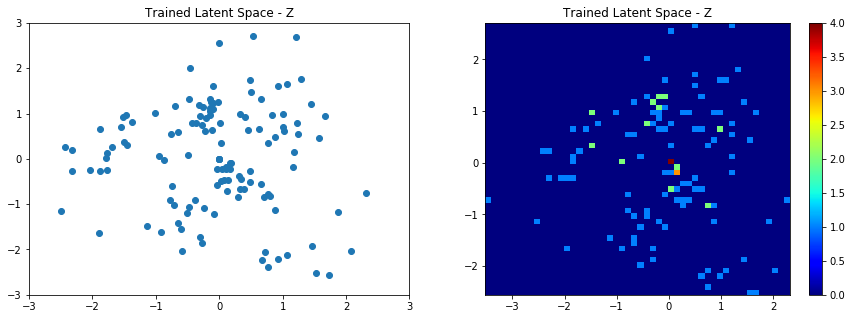

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_z_distribution(vae_model, title, z_mean=True):
    all_z = np.zeros((batch_size,network_architecture['n_z']))
        
    train_data, test_data = get_weapon_data()
    total_batch = int(train_data.num_examples / batch_size) 

    # Loop over all batches
    for i in range(total_batch):
        batch = train_data.next_batch(batch_size)
        z_dist = vae_model.calculate_z(batch)
        if z_mean:
            z_dist = vae_model.calculate_z_mean(batch)
        all_z = np.vstack((all_z, z_dist))

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.scatter(all_z[:,0], all_z[:,1])
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.title(title)
    plt.subplot(1,2,2)
    plt.hist2d(all_z[:,0], all_z[:,1], (50, 50), cmap=plt.cm.jet)
    plt.colorbar()
    plt.title(title)
    
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    show_z_distribution(network, "Untrained Latent Space", z_mean=True)
    network = vae.restore(network, "trained_vae/model.ckpt")
    show_z_distribution(network, "Trained Latent Space - Z Mean", z_mean=True)    
    show_z_distribution(network, "Trained Latent Space - Z", z_mean=False)

In [8]:
# Testing single input in latent space
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")
    
    generated = []

    random_val = np.random.normal(size=(1,network_architecture["n_z"]))
    x_test = network.decode_from_latent_space(random_val, False)
    #[generated.append(x) for x in x_test]
    generated.append(x_test)  
    
    train_data, test_data = get_weapon_data()
    print_decoded_tensors_as_dict(train_data, generated)

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
damages_first = ['78.67190383555153']
damages_last = ['59.71944221334367']
dmg_distances_first = ['9.204467842506817']
dmg_distances_last = ['101.25927458033479']
firemode_Automatic = ['0.03608744581964407']
firemode_Semi-Automatic = ['0.11947373846962106']
firemode_Single-Action = ['0.8268295832092816']
hiprecoildec = ['3.6911539005656913']
hiprecoilright = ['1.0035564846280982']
hiprecoilup = ['5.18911164140915']
hipstandbasespreaddec = ['8.65771344049021']
hipstandbasespreadinc = ['0.8263970718270051']
initialspeed = ['608.045052447358']
magsize = ['2.6426231186116276']
reloadempty = ['3.6635589239688886']
rof = ['73.58512396207433']
shotspershell = ['1.0345710360507374']
type_Shotgun = ['0.01136397841741292']
type_Pistol = ['0.14742341391154412']
type_Rifle = ['0.0005416243492631923']
type_Submachine Gun = ['0.026887180286681397']
type_Sniper Rifle = ['0.7996025611277889']
type_Light Machine Gun = ['0.0092316313804413

In [9]:
# Testing batch input in latent space
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")
    
    generated = []

    random_val = np.random.normal(size=(batch_size,network_architecture["n_z"]))
    x_test = network.decode_from_latent_space(random_val, True)
    [generated.append(x) for x in x_test]
    
    
    random_val = np.random.normal(size=(batch_size,network_architecture["n_z"]))
    x_test = network.decode_from_latent_space(random_val, True)
    [generated.append(x) for x in x_test]
    
    train_data, test_data = get_weapon_data()
    print_decoded_tensors_as_dict(train_data, generated)

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
damages_first = ['88.77761178087296', '29.5803214635597', '28.48970577410401', '31.04438006779946', '31.867614454483476', '31.548150859283048', '83.42659580728042', '30.354659899928052']
damages_last = ['48.65950414572923', '13.958906690324124', '16.25857518160927', '14.118948636335734', '22.433694200014536', '19.74206309510837', '67.83638688074315', '19.04031528298434']
dmg_distances_first = ['9.2097754446756', '11.954228411519267', '7.329175618103135', '13.650649019887574', '12.836783834035222', '8.785232690855896', '7.2181842397626905', '7.804478881149748']
dmg_distances_last = ['76.25055424161513', '39.30724605275425', '35.81494177962013', '41.36300490579431', '37.987705156053394', '34.39548923823533', '120.19969670005418', '35.29416795001319']
firemode_Automatic = ['0.03778478891814213', '0.25604104549928236', '0.6183910527290657', '0.13468037580444644', '1.0112138495954175', '0.9629258636497753', '0.0380099290220084